## Introduction<a id='introduction'></a>
**Purpose:** \
To develop a pre-screening model that predicts the probability with over 90% of a patient having late stage NASH using only readily avilable patient data

**Context:** \
Nonalcoholic steatohepatitis (NASH) affects approximately 5% of US adults and 8% of the global population. Late stages of NASH include cirrhosis of the liver, which is a major risk factor in developing cancer. Biotech companies, including Akero Therapeutics, Viking Therapeutics, Pfizer, and Novo Nordisk, have begun developing theapies for treating late stages of NASH. To be elligible for such therapies, patients must receive an MRI, which can take 2 hours per patient. With such a large patient population, pre-screening for eligiblity can expand access and can help patients in need gain access more quickly. 

**Data:** \
The data used to train this model comes from [Kaggle](https://www.kaggle.com/datasets/fedesoriano/cirrhosis-prediction-dataset), which originates from the Mayo Clinic. Additional data from [Synthea](https://console.cloud.google.com/) could also be of interest.

**Summary of data wrangling:** \
Some significant changes were made to the raw data and are listed below:
* Removed NaN stages
* Removed either non-informative or difficult-to-obtain columns
* Removed outliers
* Split according to sex
* Split according to frequency of NaNs

4 interim datasets were generated called ```female_low_nans.csv, female_high_nans.csv, male_low_nans.csv, male_high_nans.csv```

The current plan is to train a model using ```female_low_nans.csv``` and apply the model to the remaining splits. One thing to keep in mind in later notebooks is that ```Spiders``` is fairly asymmetric with the ```N``` responses dominating. It may be a good idea to balance by over-sampling the ```Y``` responses.

**Outcomes of this notebook:**
1. Features ```ALBI, APRI, FIB-4``` contain the most variance within the dataset. Other features such as ```Hepatomegaly, Spiders, Drug``` contain very little variance. It may be possible to train a model using only a subset of the available features, but that is not explored here.
2. Female and Male Low Nan are not statistically distinguishable. Female and Male may be combined for training, although with there being so few Male patients, it may be prudent to leave the Males out anyway. 

## Contents<a id='contents'></a>
* [Introduction](#introduction)
* [Contents](#contents)
* [Objectives](#objectives)
* [Statistical Descriptions of Variables](#statistical_descriptions_of_variables)
    * [Female Low Nans](#female_low_nans)
    * [Female High Nans](#female_high_nans)
    * [Male Low Nans](#male_low_nans)
    * [Male High Nans](#male_high_nans)
* [Data Roughly Separable Using t-SNE](#data_roughly_separable_using_t-sne)
* [Male and Female Not Statistically Distinguishable](#male_and_female_not_statistically_distinguishable)
    * [t-SNE of Male and Female Ambiguous](#t-sne_male_female_ambiguous)
    * [1st PCA Component Composed Mostly of ALBI, APRI, and FIB-4](#1st_pca_component_composed_mostly_albi_apri_fib-4)
    * [Permutation Bootstrap of ALBI, APRI, FIB-4](#permutation_bootstrap_albi_apri_fib-4)
    * [Statistics Female and Male Low Nans](#statistics_female_and_male_low_nans)
* [Summary](#summary)

## Objectives<a id='objectives'></a>
* Generate statistics for variables
* Identify which variables are most likely to predict NASH staging
* Identify and justify a modeling approach

## Statistical Descriptions of Variables<a id='statistical_descriptions_of_variables'></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import eda_functions as eda_f
from scipy.stats import ttest_ind
np.random.seed(42)

In [2]:
def plot_kde_stage(df, col, stage_vals=['1/2', '3', '4']):
    for s in stage_vals:
        sns.kdeplot(df[df['Stage'] == s][col], fill=True, label=s)
    plt.tick_params(axis='both', which='both', bottom=True, top=False, left=True)
    plt.legend(loc=1)
    plt.xlabel('')
    plt.title(col+' By Staging')

In [3]:
female_lownan = eda_f.add_apri_fib4_albi(pd.read_csv('../data/interim/female_low_nans.csv', index_col=0))
female_highnan = eda_f.add_apri_fib4_albi(pd.read_csv('../data/interim/female_high_nans.csv', index_col=0))
male_lownan = eda_f.add_apri_fib4_albi(pd.read_csv('../data/interim/male_low_nans.csv', index_col=0))
male_highnan = eda_f.add_apri_fib4_albi(pd.read_csv('../data/interim/male_high_nans.csv', index_col=0))

### Female Low Nans<a id='female_low_nans'></a>
**Conclusion:** \
```Cholesterol, Copper, ALBI, Triglycerides, Prothrombin, APRI, FIB-4``` appear nicely separable

In [4]:
stats_df_fln = eda_f.bs_median_stats(female_lownan, n=female_lownan.shape[0], m=10000)

In [5]:
stats_df_fln

Bilirubin     Cholesterol                     Albumin  \
F1/F2   median              0.8           280.0                        3.64   
        95.0% CI     [0.7, 1.0]  [260.5, 303.0]                [3.57, 3.77]   
F3      median              1.2           322.0                       3.615   
        95.0% CI     [1.0, 1.5]  [309.0, 350.0]  [3.55, 3.6950000000000003]   
F4      median             2.75           302.0                        3.34   
        95.0% CI     [1.8, 3.4]  [268.0, 333.0]               [3.23, 3.435]   
p-value F1/F2 vs F3         0.0             0.0                         0.0   
        F1/F2 vs F4         0.0             0.0                         0.0   
        F3 vs F4            0.0             0.0                         0.0   

                            Copper          Alk_Phos  \
F1/F2   median                44.0            1068.5   
        95.0% CI      [38.0, 57.0]   [911.0, 1282.0]   
F3      median                66.0            1257.5   
        95.0% CI      [52.0, 73.0]  [1110.0, 1548.0]   
F4      median                94.0            1507.5   
        95.0% CI     [75.0, 110.0]  [1266.5, 1768.0]   
p-value F1/F2 vs F3            0.0               0.0   
        F1/F2 vs F4            0.0               0.0   
        F3 vs F4               0.0               0.0   

                                             SGOT   Triglycerides  \
F1/F2   median                              97.65            95.0   
        95.0% CI                   [81.8, 116.25]   [86.0, 105.0]   
F3      median                            110.025           117.0   
        95.0% CI     [97.325, 126.05762499999989]  [107.0, 130.0]   
F4      median                            121.855           103.0   
        95.0% CI                  [113.15, 137.0]   [96.5, 118.0]   
p-value F1/F2 vs F3                           0.0             0.0   
        F1/F2 vs F4                           0.0             0.0   
        F3 vs F4                              0.0             0.0   

                          Platelets   Prothrombin  \
F1/F2   median                283.0         10.35   
        95.0% CI     [268.0, 312.5]  [10.1, 10.6]   
F3      median                262.0          10.2   
        95.0% CI     [239.5, 282.0]  [10.1, 10.4]   
F4      median                230.5          11.0   
        95.0% CI     [195.0, 258.0]  [10.9, 11.2]   
p-value F1/F2 vs F3             0.0           0.0   
        F1/F2 vs F4             0.0           0.0   
        F3 vs F4                0.0           0.0   

                                                         APRI  \
F1/F2   median                                       0.826108   
        95.0% CI      [0.744077306733167, 0.9255249343832022]   
F3      median                                       1.030754   
        95.0% CI      [0.957843532255771, 1.1929803820582452]   
F4      median                                       1.453337   
        95.0% CI     [1.2130871515431179, 1.7225750806985192]   
p-value F1/F2 vs F3                                       0.0   
        F1/F2 vs F4                                       0.0   
        F3 vs F4                                          0.0   

                                                        FIB-4  \
F1/F2   median                                       0.481083   
        95.0% CI      [0.399688061390214, 0.5312863315098406]   
F3      median                                        0.52488   
        95.0% CI     [0.4730144385787258, 0.5882255130416292]   
F4      median                                       0.727556   
        95.0% CI      [0.581049112917047, 0.9926679634078462]   
p-value F1/F2 vs F3                                       0.0   
        F1/F2 vs F4                                       0.0   
        F3 vs F4                                          0.0   

                                                           ALBI  
F1/F2   median                                        -0.839351  
        95.0% 

Of the numerical variables, Cholesterol, Copper, ALBI, Triglycerides (?), Prothrombin, APRI, FIB-4 look nicely separable

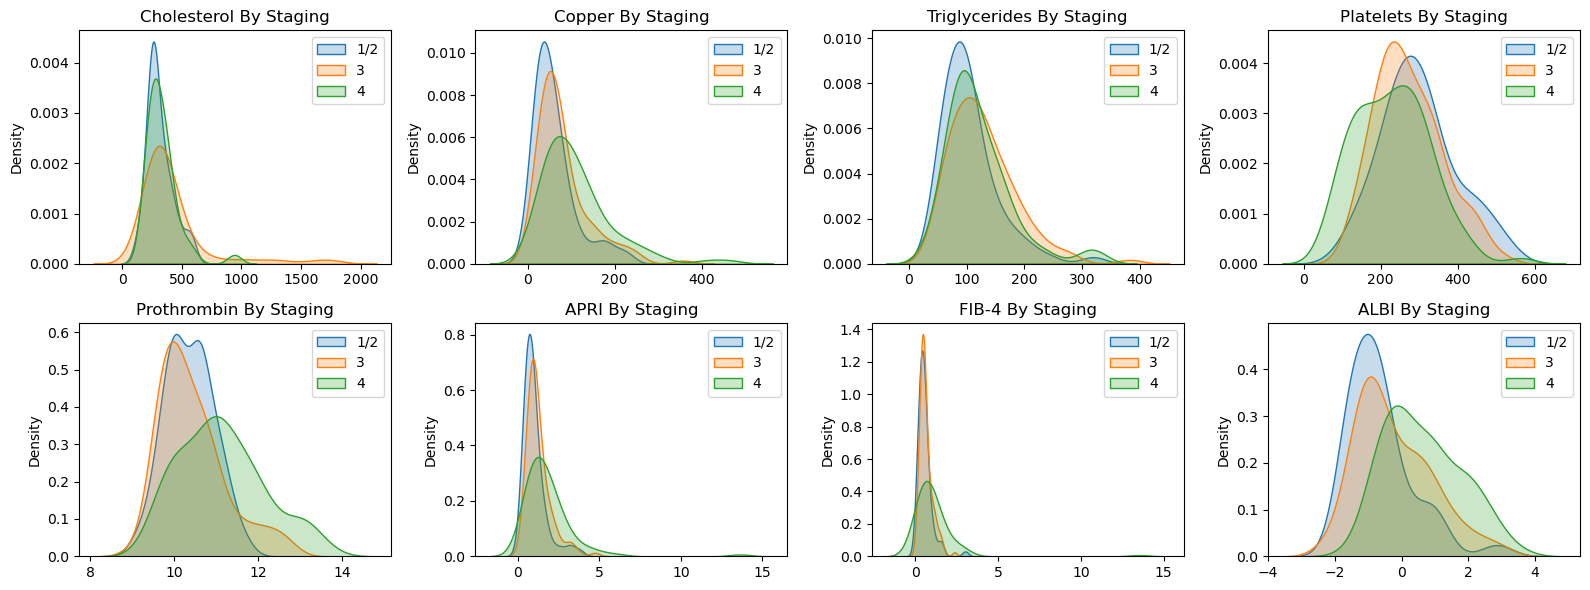

In [6]:
cols = ['Cholesterol', 'Copper', 'Triglycerides', 'Platelets', 'Prothrombin', 'APRI', 'FIB-4', 'ALBI']
plt.figure(figsize=(16,6))
for ind, col in enumerate(cols):
    plt.subplot(2,4,ind+1)
    plot_kde_stage(female_lownan, col)
plt.tight_layout()

### Female High Nans<a id='female_high_nans'></a>
Shown for completeness. This dataset is so sparse that it is not worth training on

In [7]:
import warnings

In [8]:
stats_df_fhn = eda_f.bs_median_stats(female_highnan, n=female_highnan.shape[0], m=10000)

In [9]:
stats_df_fhn

Drug Hepatomegaly     Spiders   Bilirubin  \
F1/F2   median              NaN          NaN         NaN         1.2   
        95.0% CI     [nan, nan]   [nan, nan]  [nan, nan]  [0.7, 1.6]   
F3      median              NaN          NaN         NaN         1.1   
        95.0% CI     [nan, nan]   [nan, nan]  [nan, nan]  [0.8, 1.6]   
F4      median              NaN          NaN         NaN         2.2   
        95.0% CI     [nan, nan]   [nan, nan]  [nan, nan]  [1.1, 3.2]   
p-value F1/F2 vs F3         NaN          NaN         NaN         0.0   
        F1/F2 vs F4         NaN          NaN         NaN         0.0   
        F3 vs F4            NaN          NaN         NaN         0.0   

                    Cholesterol                     Albumin      Copper  \
F1/F2   median              NaN                         3.6         NaN   
        95.0% CI     [nan, nan]                 [3.4, 3.92]  [nan, nan]   
F3      median              NaN                         3.5         NaN   
        95.0% CI     [nan, nan]               [3.33, 3.665]  [nan, nan]   
F4      median              NaN                        3.33         NaN   
        95.0% CI     [nan, nan]  [3.13, 3.4299999999999997]  [nan, nan]   
p-value F1/F2 vs F3         NaN                         0.0         NaN   
        F1/F2 vs F4         NaN                         0.0         NaN   
        F3 vs F4            NaN                         0.0         NaN   

                       Alk_Phos        SGOT Triglycerides       Platelets  \
F1/F2   median              NaN         NaN           NaN           258.0   
        95.0% CI     [nan, nan]  [nan, nan]    [nan, nan]  [229.5, 293.0]   
F3      median              NaN         NaN           NaN           233.0   
        95.0% CI     [nan, nan]  [nan, nan]    [nan, nan]  [214.0, 255.5]   
F4      median              NaN         NaN           NaN           180.0   
        95.0% CI     [nan, nan]  [nan, nan]    [nan, nan]  [155.0, 224.0]   
p-value F1/F2 vs F3         NaN         NaN           NaN             0.0   
        F1/F2 vs F4         NaN         NaN           NaN             0.0   
        F3 vs F4            NaN         NaN           NaN             0.0   

                                    Prothrombin        APRI       FIB-4  \
F1/F2   median                            10.35         NaN         NaN   
        95.0% CI                   [10.1, 11.0]  [nan, nan]  [nan, nan]   
F3      median                             10.5         NaN         NaN   
        95.0% CI     [10.350000000000001, 10.6]  [nan, nan]  [nan, nan]   
F4      median                             10.9         NaN         NaN   
        95.0% CI                   [10.6, 11.1]  [nan, nan]  [nan, nan]   
p-value F1/F2 vs F3                         0.0         NaN         NaN   
        F1/F2 vs F4                         0.0         NaN         NaN   
        F3 vs F4                            0.0         NaN         NaN   

                                                             ALBI  
F1/F2   median                                          -0.486733  
        95.0% CI        [-1.060880497614673, 0.03415871079154975]  
F3      median                                           -0.40924  
        95.0% CI     [-0.6702055536759408, -0.013201924430205292]  
F4      median                                           0.334081  
        95.0% CI       [-0.20384128920845024, 0.5754764771632557]  
p-value F1/F2 vs F3                                           0.0  
        F1/F2 vs F4                                           0.0  
        F3 vs F4                                              0.0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


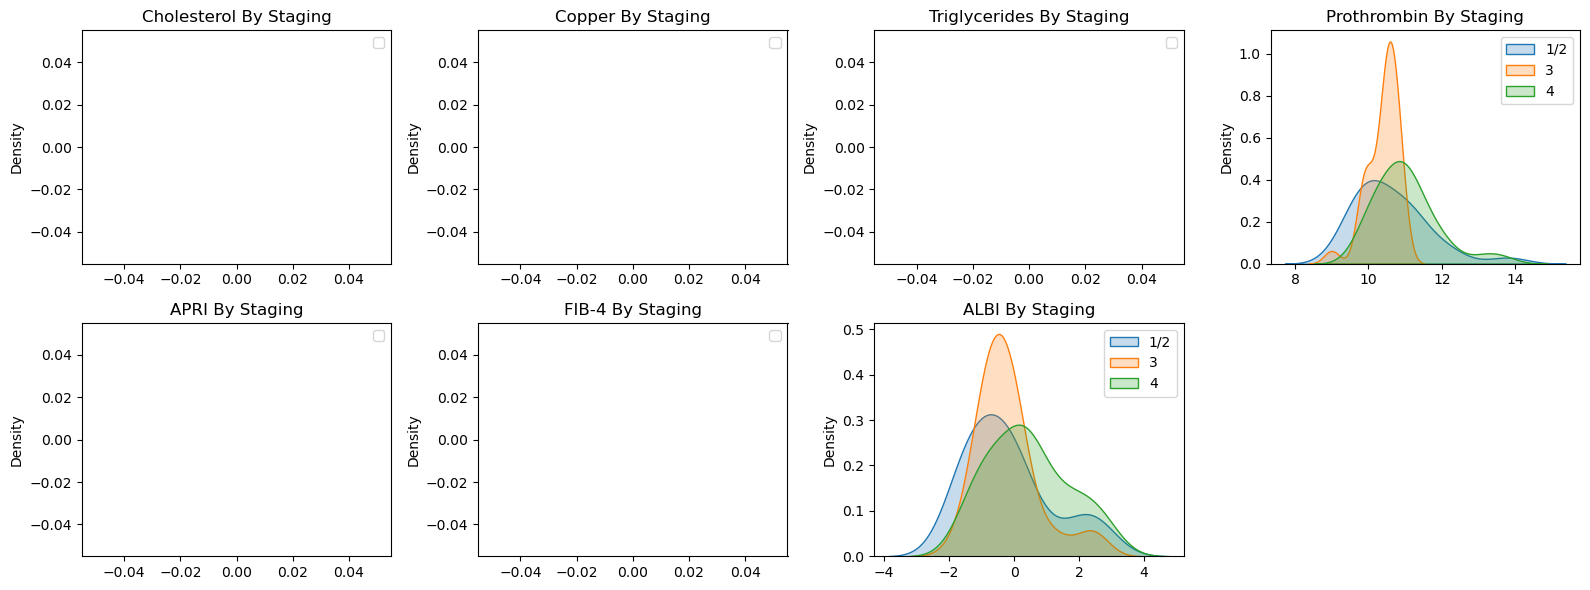

In [10]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    cols = ['Cholesterol', 'Copper', 'Triglycerides', 'Prothrombin', 'APRI', 'FIB-4', 'ALBI']
    plt.figure(figsize=(16,6))
    for ind, col in enumerate(cols):
        plt.subplot(2,4,ind+1)
        plot_kde_stage(female_highnan, col)
    plt.tight_layout()

### Male Low Nans<a id='male_low_nans'></a>
**Conclusion:** \
```Cholesterol, Copper, ALBI, Triglycerides, Prothrombin, APRI, FIB-4``` appear nicely separable.\
Distributions of aforementioned variables appear to be different from that of the female low nan set, but further testing is needed.

In [11]:
stats_df_mln = eda_f.bs_median_stats(male_lownan, n=60, m=10000)

In [12]:
stats_df_mln

Bilirubin     Cholesterol       Albumin          Copper  \
F1/F2   median              1.8           416.0          3.94           124.0   
        95.0% CI     [0.9, 2.3]  [316.0, 460.0]   [3.37, 4.0]   [81.0, 158.0]   
F3      median              2.4           418.0         3.715           212.5   
        95.0% CI     [2.0, 3.2]  [317.0, 427.0]  [3.46, 3.93]  [105.0, 243.0]   
F4      median              1.5           249.0          3.48           100.0   
        95.0% CI     [1.2, 4.0]  [232.0, 257.0]  [3.08, 3.79]   [73.0, 200.0]   
p-value F1/F2 vs F3         0.0             0.0           0.0             0.0   
        F1/F2 vs F4         0.0             0.0           0.0             0.0   
        F3 vs F4            0.0             0.0           0.0             0.0   

                             Alk_Phos            SGOT   Triglycerides  \
F1/F2   median                 1601.0          122.45           118.0   
        95.0% CI     [1098.0, 5084.4]   [86.0, 179.8]   [93.0, 188.0]   
F3      median                 1489.5           127.0           162.0   
        95.0% CI     [1040.0, 2424.0]  [114.7, 130.2]  [126.0, 194.0]   
F4      median                 1015.0            98.0           109.5   
        95.0% CI      [746.0, 1142.0]   [75.0, 133.3]   [91.0, 128.0]   
p-value F1/F2 vs F3               0.0             0.0             0.0   
        F1/F2 vs F4               0.0             0.0             0.0   
        F3 vs F4                  0.0             0.0             0.0   

                          Platelets   Prothrombin  \
F1/F2   median                283.5          10.2   
        95.0% CI     [191.5, 349.5]   [9.9, 10.6]   
F3      median                260.0          11.0   
        95.0% CI     [213.0, 306.0]  [10.6, 11.2]   
F4      median                212.0          11.2   
        95.0% CI     [156.0, 238.0]  [10.9, 11.3]   
p-value F1/F2 vs F3             0.0           0.0   
        F1/F2 vs F4             0.0           0.0   
        F3 vs F4                0.0           0.0   

                                                        APRI  \
F1/F2   median                                      1.133859   
        95.0% CI     [0.9132608031236746, 1.501224624180907]   
F3      median                                      1.064323   
        95.0% CI      [0.946220930232558, 1.572463768115942]   
F4      median                                      1.227083   
        95.0% CI       [0.879201680672269, 1.61371237458194]   
p-value F1/F2 vs F3                                 0.000003   
        F1/F2 vs F4                                      0.0   
        F3 vs F4                                         0.0   

                                                        FIB-4  \
F1/F2   median                                       0.644718   
        95.0% CI     [0.4585722068562367, 0.7470708198382052]   
F3      median                                       0.551807   
        95.0% CI      [0.480705544220644, 0.6726561875914585]   
F4      median                                       0.879961   
        95.0% CI      [0.6708844486623705, 1.107106073189934]   
p-value F1/F2 vs F3                                       0.0   
        F1/F2 vs F4                                       0.0   
        F3 vs F4                                          0.0   

                                                           ALBI  
F1/F2   median                                        -0.234268  
        95.0% CI      [-0.6932019244302055, 0.4092035692591631]  
F3      median                                          0.31975  
        95.0% CI     [-0.06805474387025967, 0.6982035692591628]  
F4      median                                         0.271151  
        95.0% CI     [-0.30938399688198626, 0.8775888074439497]  
p-value F1/F2 vs F3                                         0.0  
        F1/F2 vs F4                                         0.0  
        F3 vs F4                                            0.0

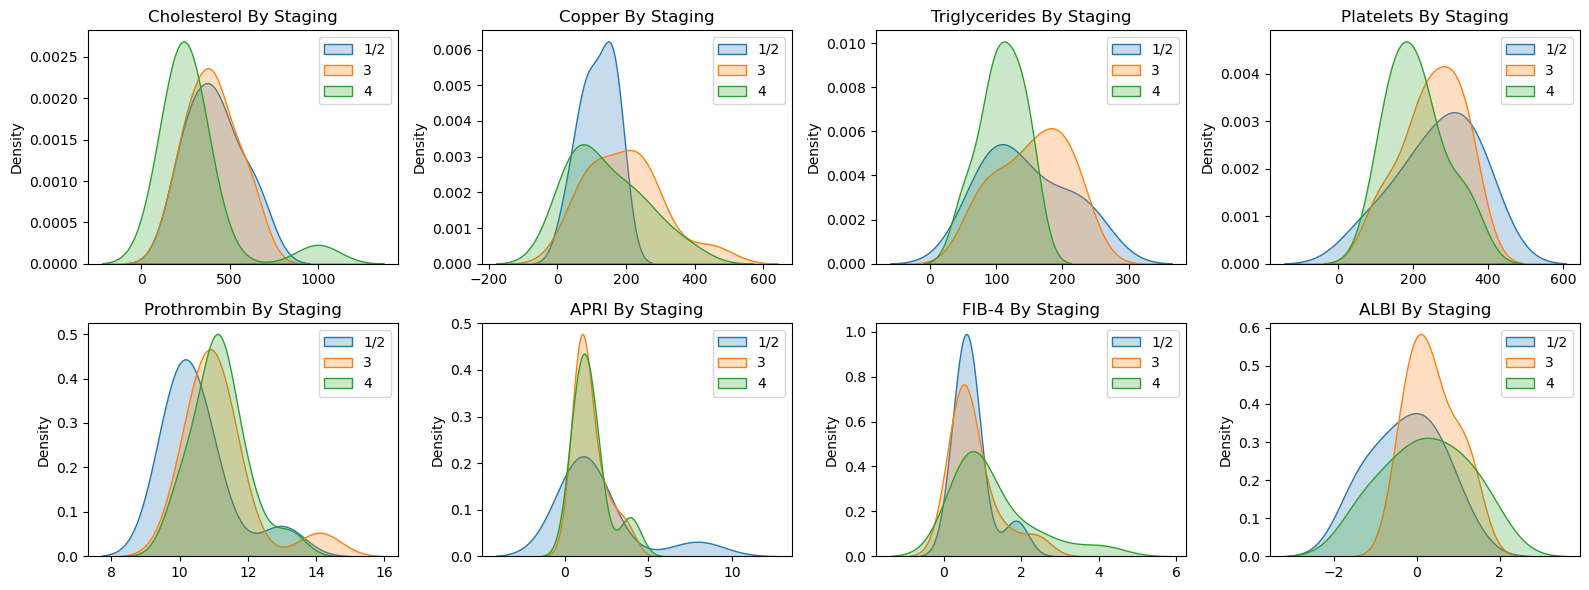

In [13]:
cols = ['Cholesterol', 'Copper', 'Triglycerides', 'Platelets', 'Prothrombin', 'APRI', 'FIB-4', 'ALBI']
plt.figure(figsize=(16,6))
for ind, col in enumerate(cols):
    plt.subplot(2,4,ind+1)
    plot_kde_stage(male_lownan, col)
plt.tight_layout()

### Male High Nans<a id='male_high_nans'></a>
Shown for completeness. This dataset is so sparse that it is not worth training on

In [15]:
stats_df_mhn = eda_f.bs_median_stats(male_highnan, n=60, m=10000)

In [16]:
stats_df_mhn

Drug Hepatomegaly     Spiders   Bilirubin  \
F1/F2   median              NaN          NaN         NaN         2.2   
        95.0% CI     [nan, nan]   [nan, nan]  [nan, nan]  [0.9, 3.5]   
F3      median              NaN          NaN         NaN        2.35   
        95.0% CI     [nan, nan]   [nan, nan]  [nan, nan]  [1.7, 3.0]   
F4      median              NaN          NaN         NaN         1.5   
        95.0% CI     [nan, nan]   [nan, nan]  [nan, nan]  [1.3, 1.7]   
p-value F1/F2 vs F3         NaN          NaN         NaN         0.0   
        F1/F2 vs F4         NaN          NaN         NaN         0.0   
        F3 vs F4            NaN          NaN         NaN         0.0   

                    Cholesterol       Albumin      Copper    Alk_Phos  \
F1/F2   median              NaN         3.385         NaN         NaN   
        95.0% CI     [nan, nan]  [3.14, 3.63]  [nan, nan]  [nan, nan]   
F3      median              NaN          3.39         NaN         NaN   
        95.0% CI     [nan, nan]  [3.15, 3.63]  [nan, nan]  [nan, nan]   
F4      median              NaN         3.535         NaN         NaN   
        95.0% CI     [nan, nan]  [3.41, 3.66]  [nan, nan]  [nan, nan]   
p-value F1/F2 vs F3         NaN       0.41554         NaN         NaN   
        F1/F2 vs F4         NaN           0.0         NaN         NaN   
        F3 vs F4            NaN           0.0         NaN         NaN   

                           SGOT Triglycerides       Platelets   Prothrombin  \
F1/F2   median              NaN           NaN           258.0          11.3   
        95.0% CI     [nan, nan]    [nan, nan]  [191.0, 325.0]  [10.3, 12.3]   
F3      median              NaN           NaN           193.0          10.1   
        95.0% CI     [nan, nan]    [nan, nan]  [166.0, 220.0]  [10.0, 10.2]   
F4      median              NaN           NaN           175.5         10.95   
        95.0% CI     [nan, nan]    [nan, nan]   [92.0, 259.0]  [10.9, 11.0]   
p-value F1/F2 vs F3         NaN           NaN             0.0           0.0   
        F1/F2 vs F4         NaN           NaN             0.0           0.0   
        F3 vs F4            NaN           NaN             0.0           0.0   

                           APRI       FIB-4  \
F1/F2   median              NaN         NaN   
        95.0% CI     [nan, nan]  [nan, nan]   
F3      median              NaN         NaN   
        95.0% CI     [nan, nan]  [nan, nan]   
F4      median              NaN         NaN   
        95.0% CI     [nan, nan]  [nan, nan]   
p-value F1/F2 vs F3         NaN         NaN   
        F1/F2 vs F4         NaN         NaN   
        F3 vs F4            NaN         NaN   

                                                            ALBI  
F1/F2   median                                          0.120246  
        95.0% CI       [-0.3505660693337673, 0.5910574148194274]  
F3      median                                          0.888165  
        95.0% CI        [0.8449067349921693, 0.9314226973862296]  
F4      median                                         -0.184459  
        95.0% CI     [-0.21234128920844997, -0.1565773026137709]  
p-value F1/F2 vs F3                                          0.0  
        F1/F2 vs F4                                          0.0  
        F3 vs F4                                             0.0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


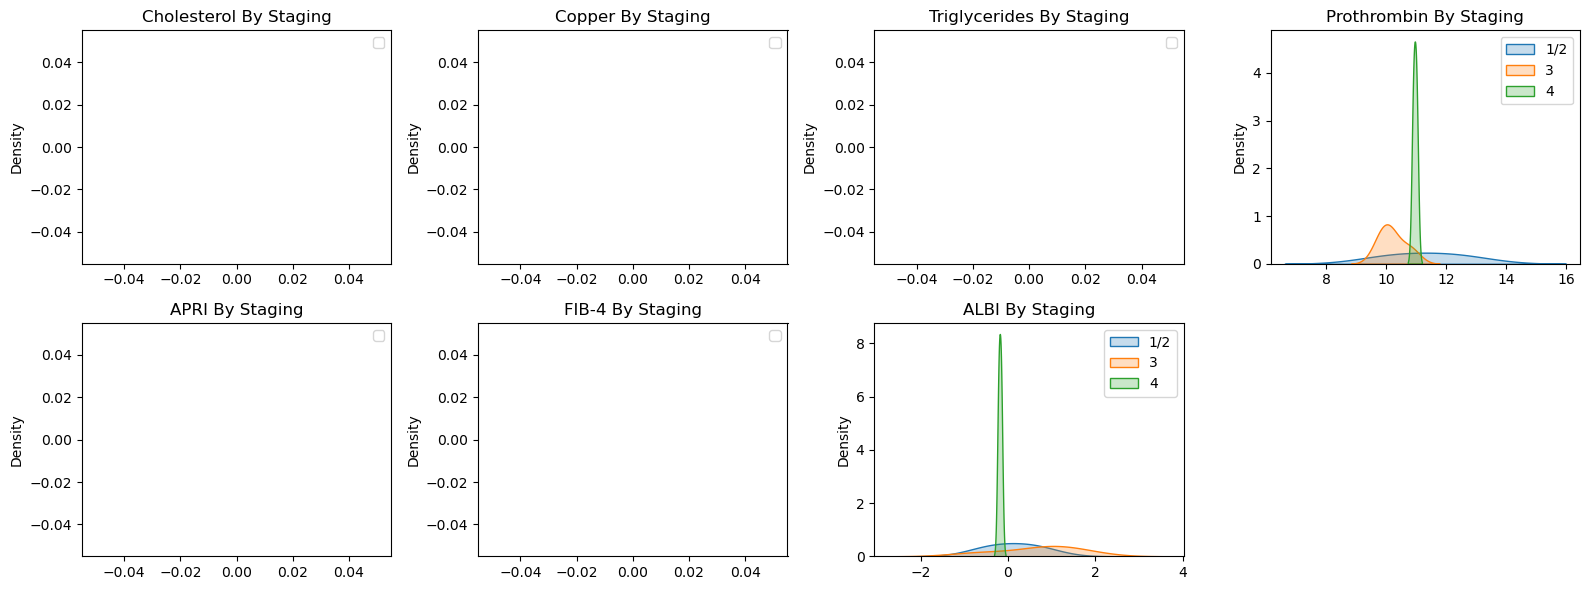

In [14]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    cols = ['Cholesterol', 'Copper', 'Triglycerides', 'Prothrombin', 'APRI', 'FIB-4', 'ALBI']
    plt.figure(figsize=(16,6))
    for ind, col in enumerate(cols):
        plt.subplot(2,4,ind+1)
        plot_kde_stage(male_highnan, col)
    plt.tight_layout();

## Data Roughly Separable Using t-SNE<a id='data_roughly_separable_using_t-sne'></a>
**Conclusion:** \
It is very difficult to cluster the data according to fibrosis staging using t-SNE, although there is some separation. \
Worth noting that could not generate a qualitatively better clustering by using a subset of the available features.

In [17]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin

In [18]:
class OneHotNan(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        ohe = OneHotEncoder(sparse_output=False)
        X_oh = ohe.fit_transform(X)
        
        if True not in pd.isnull(ohe.categories_):
            X_oh = pd.DataFrame(X_oh, columns=ohe.categories_[0])
        if True in pd.isnull(ohe.categories_):
            for ind, val in enumerate(ohe.categories_[0]):
                if pd.isnull(val):
                    nan_col = ind
            nan_rows = [ind for ind, val in enumerate(X_oh[:, nan_col]) if val > 0]

            X_oh = pd.DataFrame(X_oh, columns=ohe.categories_[0])
            X_oh.loc[nan_rows,:] = pd.NA
            X_oh = X_oh.drop(columns=ohe.categories_[0][nan_col])
        
        return X_oh

class CategoricalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        OH_NaN = OneHotNan()

        X_cat = pd.DataFrame()
        for cat_col in self.columns:
            df = OH_NaN.fit_transform(X[[cat_col]])

            new_cols = [cat_col+'_'+s for s in df.columns]
            X_cat = pd.concat([X_cat, df.rename(columns=dict(zip(df.columns, new_cols)))], axis=1)

        return X_cat

class BinCategoricalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    def fit(self, X, Y=None):
        return self
    def transform(self, X):
        X_bin = pd.DataFrame()
        for col in self.columns:
            X_bin = pd.concat([X_bin, X[[col]].replace(('Y','N'), (1,0))], axis=1)
        return X_bin

class NumericalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        scaler = StandardScaler()
        X_num = pd.DataFrame(scaler.fit_transform(X[self.columns]), columns=self.columns)
        return X_num

In [19]:
union = FeatureUnion([
    ('bin_trans', BinCategoricalTransformer(columns=['Hepatomegaly', 'Spiders'])),
    ('cat_trans', CategoricalTransformer(columns=['Drug', 'Edema'])),
    ('num_trans', NumericalTransformer(columns=['Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT',
                                                'Triglycerides', 'Platelets', 'Prothrombin', 'ALBI', 'APRI', 'FIB-4']))
])
pipe = Pipeline([
    ('features', union),
    ('knn_impute', KNNImputer()),
    ('pca', PCA(n_components=0.95, svd_solver='full'))
])

In [20]:
df = female_lownan
X = pipe.fit_transform(df)
s2_mask = [ind for ind, val in enumerate(df['Stage']) if val == '1/2']
s3_mask = [ind for ind, val in enumerate(df['Stage']) if val == '3']
s4_mask = [ind for ind, val in enumerate(df['Stage']) if val == '4']

1499


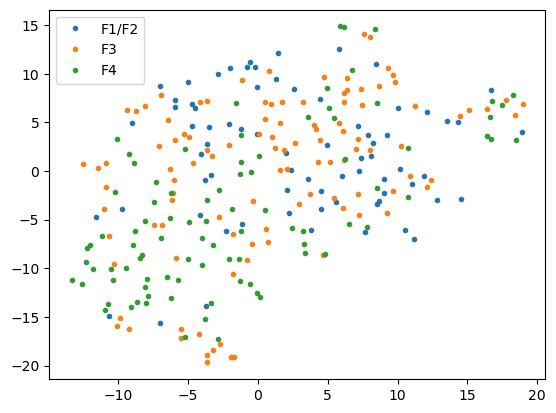

In [21]:
tsne = TSNE(perplexity=30, early_exaggeration=12, n_iter=5000, learning_rate=60)
X_embedded = tsne.fit_transform(X)
plt.plot(X_embedded[s2_mask,0], X_embedded[s2_mask,1], '.', label='F1/F2')
plt.plot(X_embedded[s3_mask,0], X_embedded[s3_mask,1], '.', label='F3')
plt.plot(X_embedded[s4_mask,0], X_embedded[s4_mask,1], '.', label='F4')
plt.legend(loc=2)
print(tsne.n_iter_)

In [22]:
union = FeatureUnion([
    ('bin_trans', BinCategoricalTransformer(columns=['Hepatomegaly', 'Spiders'])),
    ('cat_trans', CategoricalTransformer(columns=['Drug', 'Edema'])),
    ('num_trans', NumericalTransformer(columns=['Cholesterol', 'Copper', 'Triglycerides', 'Prothrombin', 'ALBI', 'APRI', 'FIB-4']))
])
pipe = Pipeline([
    ('features', union),
    ('knn_impute', KNNImputer()),
    ('pca', PCA(n_components=0.95, svd_solver='full'))
])

In [23]:
df = female_lownan
X = pipe.fit_transform(df)
s2_mask = [ind for ind, val in enumerate(df['Stage']) if val == '1/2']
s3_mask = [ind for ind, val in enumerate(df['Stage']) if val == '3']
s4_mask = [ind for ind, val in enumerate(df['Stage']) if val == '4']

899 0.5160070657730103


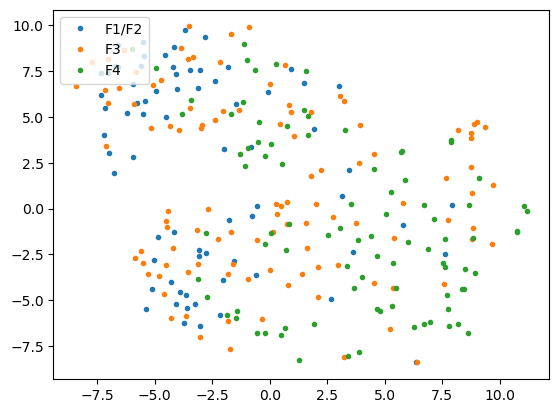

In [24]:
tsne = TSNE(perplexity=50, early_exaggeration=12, n_iter=5000, learning_rate=60)
X_embedded = tsne.fit_transform(X)
plt.plot(X_embedded[s2_mask,0], X_embedded[s2_mask,1], '.', label='F1/F2')
plt.plot(X_embedded[s3_mask,0], X_embedded[s3_mask,1], '.', label='F3')
plt.plot(X_embedded[s4_mask,0], X_embedded[s4_mask,1], '.', label='F4')
plt.legend(loc=2)
print(tsne.n_iter_, tsne.kl_divergence_)

It may be possible that could get away with training with less than ```['Hepatomegaly', 'Spiders', 'Drug', 'Edema','Cholesterol', 'Copper', 'Triglycerides', 'Prothrombin', 'ALBI', 'APRI', 'FIB-4']```, with this set, able to achieve slight separation in t-SNE

In [25]:
# using all columns except for stage and sex
union = FeatureUnion([
    ('bin_trans', BinCategoricalTransformer(columns=['Hepatomegaly', 'Spiders'])),
    ('cat_trans', CategoricalTransformer(columns=['Drug', 'Edema'])),
    ('num_trans', NumericalTransformer(columns=['Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 
                                                'Alk_Phos', 'SGOT', 'Triglycerides', 'Platelets', 'Prothrombin', 'ALBI', 'APRI', 'FIB-4']))
])
pipe = Pipeline([
    ('features', union),
    ('knn_impute', KNNImputer()),
    ('pca', PCA(n_components=0.95, svd_solver='full'))
])

In [26]:
df = female_lownan
X = pipe.fit_transform(df)
s2_mask = [ind for ind, val in enumerate(df['Stage']) if val == '1/2']
s3_mask = [ind for ind, val in enumerate(df['Stage']) if val == '3']
s4_mask = [ind for ind, val in enumerate(df['Stage']) if val == '4']

1349 0.8145968914031982


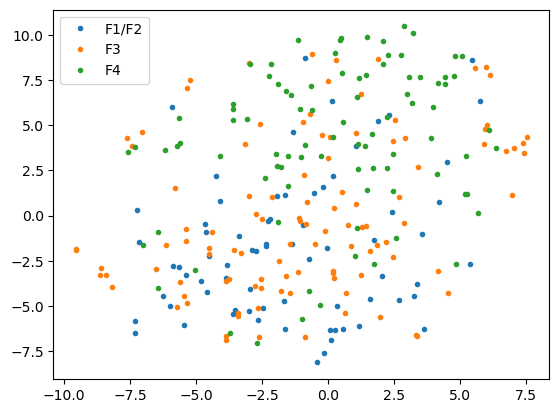

In [27]:
tsne = TSNE(perplexity=45, early_exaggeration=90, n_iter=5000, learning_rate=30)
X_embedded = tsne.fit_transform(X)
plt.plot(X_embedded[s2_mask,0], X_embedded[s2_mask,1], '.', label='F1/F2')
plt.plot(X_embedded[s3_mask,0], X_embedded[s3_mask,1], '.', label='F3')
plt.plot(X_embedded[s4_mask,0], X_embedded[s4_mask,1], '.', label='F4')
plt.legend(loc=2)
print(tsne.n_iter_, tsne.kl_divergence_)

## Male and Female Not Statistically Distinguishable<a id='male_and_female_not_statistically_distinguishable'></a>

### t-SNE of Male and Female Ambiguous<a id='t-sne_male_female_ambiguous'></a>
Not worth pursuing

In [81]:
female_lownan = add_apri_fib4_albi(pd.read_csv('../data/interim/female_low_nans.csv', index_col=0))
male_lownan = add_apri_fib4_albi(pd.read_csv('../data/interim/male_low_nans.csv', index_col=0))

In [104]:
# using all columns except for stage and sex
union = FeatureUnion([
    ('bin_trans', BinCategoricalTransformer(columns=['Hepatomegaly', 'Spiders'])),
    ('cat_trans', CategoricalTransformer(columns=['Drug', 'Edema'])),
    ('num_trans', NumericalTransformer(columns=['Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 
                                                'Alk_Phos', 'SGOT', 'Triglycerides', 'Platelets', 'Prothrombin', 'ALBI', 'APRI', 'FIB-4']))
])
pipe = Pipeline([
    ('features', union),
    ('knn_impute', KNNImputer()),
    ('pca', PCA(n_components=0.95, svd_solver='full'))
])

In [105]:
X = pd.concat([female_lownan.drop(columns='Sex'), male_lownan.drop(columns='Sex')])

In [88]:
male_lownan.shape

(36, 19)

In [106]:
tsne = TSNE(perplexity=60, early_exaggeration=90, n_iter=5000, learning_rate=30)

X_pipe = pipe.fit_transform(X)
X_embed = tsne.fit_transform(X_pipe)

mask_fln_2 = [ind for ind, val in enumerate(female_lownan['Stage']) if val == '1/2']
mask_fln_3 = [ind for ind, val in enumerate(female_lownan['Stage']) if val == '3']
mask_fln_4 = [ind for ind, val in enumerate(female_lownan['Stage']) if val == '4']

mask_mln_2 = [ind for ind, val in enumerate(male_lownan['Stage']) if val == '1/2']
mask_mln_3 = [ind for ind, val in enumerate(male_lownan['Stage']) if val == '3']
mask_mln_4 = [ind for ind, val in enumerate(male_lownan['Stage']) if val == '4']

1499 0.6792812347412109


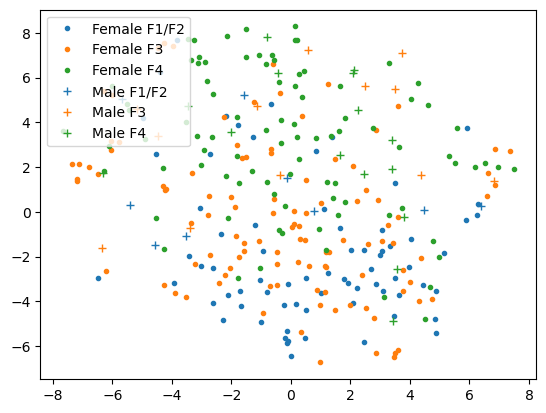

In [107]:
plt.plot(X_embed[:-36][mask_fln_2, 0], X_embed[:-36][mask_fln_2, 1], '.', label='Female F1/F2', color='C0')
plt.plot(X_embed[:-36][mask_fln_3, 0], X_embed[:-36][mask_fln_3, 1], '.', label='Female F3', color='C1')
plt.plot(X_embed[:-36][mask_fln_4, 0], X_embed[:-36][mask_fln_4, 1], '.', label='Female F4', color='C2')

plt.plot(X_embed[-36:][mask_mln_2, 0], X_embed[-36:][mask_mln_2, 1], '+', label='Male F1/F2', color='C0')
plt.plot(X_embed[-36:][mask_mln_3, 0], X_embed[-36:][mask_mln_3, 1], '+', label='Male F3', color='C1')
plt.plot(X_embed[-36:][mask_mln_4, 0], X_embed[-36:][mask_mln_4, 1], '+', label='Male F4', color='C2')

plt.legend(loc=2)
print(tsne.n_iter_, tsne.kl_divergence_)

Could try looking at which columns hold most variance from pca, then show that sex is statistically distinguishable for those columns

### 1st PCA Component Composed Mostly of ALBI, APRI, and FIB-4<a id='1st_pca_component_composed_mostly_albi_apri_fib-4'></a>
This analysis is to verify that statistical difference in ALBI, APRI, FIB-4 are likely most important. \
However, justification comes from domain knowledge. ALBI, APRI, and FIB-4 have been used as indicators for fibrosis in Hep C patients.

In [24]:
bin_cols = pipe['features']['bin_trans'].transform(male_lownan).columns
cat_cols = pipe['features']['cat_trans'].transform(male_lownan).columns
num_cols = pipe['features']['num_trans'].transform(male_lownan).columns

In [25]:
pca_feature_names = list(np.concatenate([bin_cols.values, cat_cols.values, num_cols.values]))

In [26]:
pca_df = pd.DataFrame(abs(pipe['pca'].components_), columns=pca_feature_names)

In [27]:
pca_df.style.background_gradient(cmap='Blues')

,Hepatomegaly,Spiders,Drug_D-penicillamine,Drug_Placebo,Edema_N,Edema_S,Edema_Y,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Triglycerides,Platelets,Prothrombin,ALBI,APRI,FIB-4
0,0.090002,0.076284,0.009362,0.009362,0.073419,0.023099,0.050320,0.055199,0.374038,0.126401,0.285186,0.262879,0.065462,0.319310,0.120457,0.212975,0.273701,0.424413,0.384547,0.314733
1,0.055318,0.027098,0.044116,0.044116,0.018740,0.001237,0.017502,0.202452,0.226093,0.399796,0.038672,0.252903,0.329499,0.021488,0.298591,0.410548,0.115320,0.209640,0.300232,0.400165
2,0.074913,0.023057,0.067235,0.067235,0.076460,0.040339,0.036121,0.635585,0.005068,0.201195,0.358475,0.092532,0.181598,0.467826,0.113625,0.023971,0.224817,0.077899,0.254182,0.089175
3,0.059281,0.076779,0.034167,0.034167,0.021485,0.009625,0.011860,0.374879,0.155240,0.228333,0.078770,0.148789,0.516933,0.004294,0.505363,0.080673,0.423491,0.041175,0.004198,0.179593
4,0.085923,0.113946,0.086068,0.086068,0.024135,0.005475,0.018660,0.223172,0.182570,0.135807,0.126711,0.182017,0.657948,0.278245,0.308058,0.202863,0.125910,0.191191,0.250031,0.227594
5,0.041702,0.054834,0.162837,0.162837,0.026641,0.026328,0.000313,0.150379,0.105564,0.333200,0.525763,0.394504,0.011546,0.255980,0.464246,0.160646,0.196148,0.116956,0.032786,0.061329
6,0.043967,0.016320,0.006593,0.006593,0.051994,0.039060,0.012934,0.275650,0.253432,0.319429,0.476224,0.322333,0.031979,0.058133,0.152937,0.197590,0.590159,0.046909,0.041111,0.037039
7,0.130485,0.032977,0.060388,0.060388,0.010998,0.021734,0.010736,0.201695,0.039642,0.223638,0.038896,0.566982,0.234013,0.227084,0.274530,0.587996,0.011431,0.082978,0.014005,0.154882
8,0.006746,0.016032,0.294653,0.294653,0.097298,0.057036,0.040261,0.212866,0.117532,0.431901,0.307272,0.425290,0.155563,0.071305,0.206431,0.415708,0.195434,0.079826,0.029993,0.024232
9,0.096350,0.059613,0.590627,0.590627,0.069903,0.035167,0.034737,0.343171,0.110986,0.161522,0.017339,0.106842,0.089342,0.161912,0.175055,0.137072,0.148442,0.081196,0.014982,0.042202


### Permutation Bootstrap of ALBI, APRI, FIB-4<a id='permutation_bootstrap_albi_apri_fib-4'></a>
**Conclusion:** \
Female and Male are not statistically distinguishable.

In [28]:
trunc_female = female_lownan[['Stage', 'ALBI', 'APRI', 'FIB-4']]
trunc_male = male_lownan[['Stage', 'ALBI', 'APRI', 'FIB-4']]
obs_diff = trunc_male.groupby('Stage').mean() - trunc_female.groupby('Stage').mean()

In [29]:
eda_f.perm_bs_pval(trunc_female, trunc_male, m=10000)

,ALBI,APRI,FIB-4
Stage,,,
1/2,0.3786,0.2425,0.4038
3,0.1226,0.4765,0.4588
4,0.3010,0.5251,0.6446


In [30]:
np.abs(eda_f.perm_bs_means(trunc_female, trunc_male, m=1))

array([[[0.2887807 , 1.45696056, 0.32120236],
        [0.65766996, 0.02419342, 0.1226149 ],
        [0.20625197, 1.2738051 , 1.20625165]]])

In [31]:
obs_diff

,ALBI,APRI,FIB-4
Stage,,,
1/2,0.392350,0.972509,0.179837
3,0.609949,0.249993,0.155641
4,-0.414408,-0.288195,0.175711


### Statistics Female and Male Low Nans<a id='statistics_female_and_male_low_nans'></a>

In [32]:
lownan = pd.concat([female_lownan, male_lownan])
stats_df_ln = eda_f.bs_median_stats(lownan, n=lownan.shape[0], m=10000)

In [33]:
stats_df_ln

Bilirubin     Cholesterol       Albumin         Copper  \
F1/F2   median              0.9           286.0          3.65           50.0   
        95.0% CI     [0.7, 1.0]  [263.0, 325.5]  [3.58, 3.77]   [40.0, 67.0]   
F3      median              1.3           324.0          3.63           68.0   
        95.0% CI     [1.1, 1.9]  [313.0, 354.0]   [3.55, 3.7]   [56.0, 75.0]   
F4      median              2.6           288.0          3.35           95.0   
        95.0% CI     [1.8, 3.3]  [261.0, 325.0]  [3.25, 3.47]  [77.0, 110.0]   
p-value F1/F2 vs F3         0.0             0.0           0.0            0.0   
        F1/F2 vs F4         0.0             0.0           0.0            0.0   
        F3 vs F4            0.0             0.0           0.0            0.0   

                             Alk_Phos              SGOT   Triglycerides  \
F1/F2   median                 1087.0              99.0            97.0   
        95.0% CI      [975.0, 1345.0]   [85.25, 116.25]   [88.0, 108.0]   
F3      median                 1257.5           112.075           119.0   
        95.0% CI     [1110.0, 1553.0]   [99.975, 127.0]  [109.0, 135.0]   
F4      median                 1406.0             120.9           104.0   
        95.0% CI     [1212.0, 1622.0]  [106.95, 134.85]   [98.5, 118.0]   
p-value F1/F2 vs F3               0.0               0.0             0.0   
        F1/F2 vs F4               0.0               0.0             0.0   
        F3 vs F4                  0.0               0.0             0.0   

                          Platelets   Prothrombin  \
F1/F2   median                283.0          10.3   
        95.0% CI     [268.5, 312.0]  [10.1, 10.6]   
F3      median                262.0          10.3   
        95.0% CI     [240.0, 281.0]  [10.2, 10.6]   
F4      median                225.0          11.0   
        95.0% CI     [195.0, 248.0]  [10.9, 11.2]   
p-value F1/F2 vs F3             0.0           0.0   
        F1/F2 vs F4             0.0           0.0   
        F3 vs F4                0.0           0.0   

                                                         APRI  \
F1/F2   median                                       0.873134   
        95.0% CI     [0.7700138403263403, 0.9341517857142857]   
F3      median                                       1.037582   
        95.0% CI                [0.96875, 1.1774861878453038]   
F4      median                                       1.432849   
        95.0% CI      [1.2091165413533835, 1.664612676056338]   
p-value F1/F2 vs F3                                       0.0   
        F1/F2 vs F4                                       0.0   
        F3 vs F4                                          0.0   

                                                         FIB-4  \
F1/F2   median                                        0.490198   
        95.0% CI     [0.41343080726774095, 0.5485357668208127]   
F3      median                                         0.52392   
        95.0% CI       [0.4841718312985277, 0.601845645885009]   
F4      median                                        0.742555   
        95.0% CI      [0.6214443880407501, 0.9483585048457638]   
p-value F1/F2 vs F3                                        0.0   
        F1/F2 vs F4                                        0.0   
        F3 vs F4                                           0.0   

                                                           ALBI  
F1/F2   median                                        -0.825349  
        95.0% CI      [-0.9940311774419315, -0.574895373871616]  
F3      median                                        -0.388487  
        95.0% CI     [-0.659895373871616, -0.06805474387025967]  
F4      median                                         0.417127  
        95.0% CI      [0.09976668294527258, 0.8283989872482747]  
p-value F1/F2 vs F3                                         0.0  
        F1/F2 vs F4                                         0.0  
        F3 vs F4                 

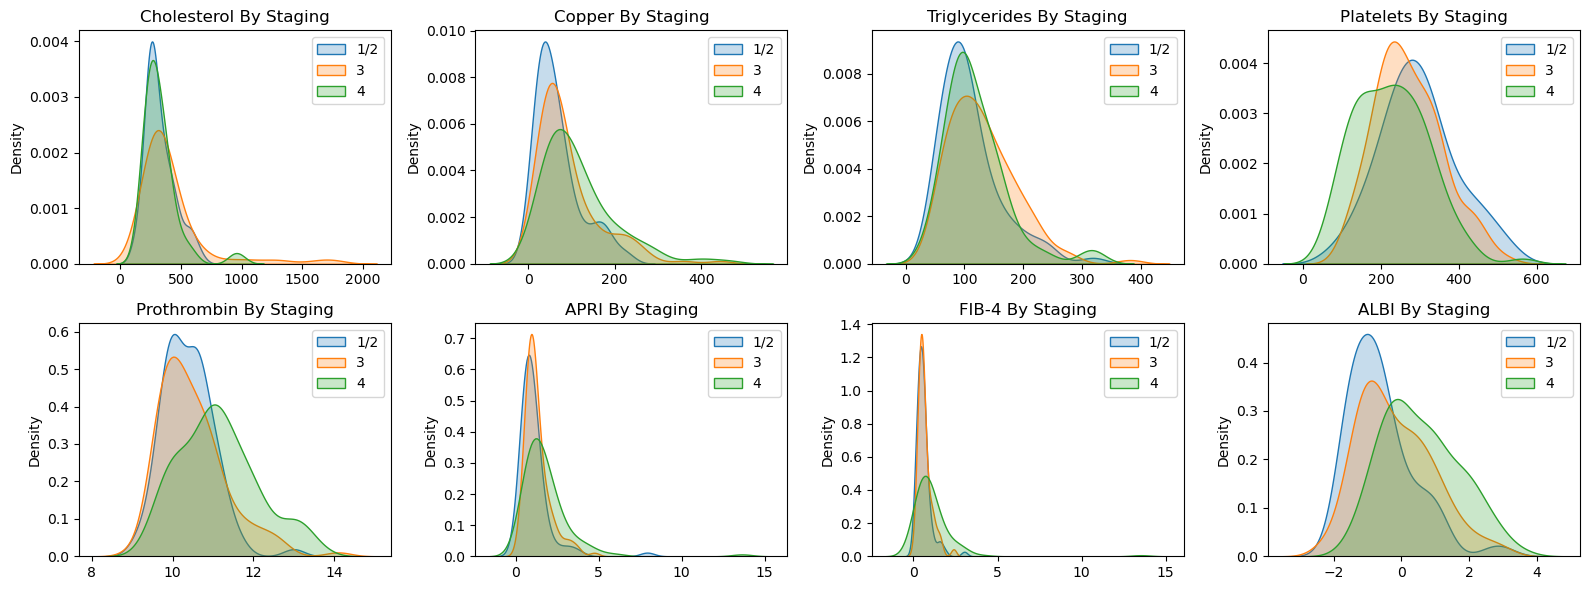

In [34]:
cols = ['Cholesterol', 'Copper', 'Triglycerides', 'Platelets', 'Prothrombin', 'APRI', 'FIB-4', 'ALBI']
plt.figure(figsize=(16,6))
for ind, col in enumerate(cols):
    plt.subplot(2,4,ind+1)
    plot_kde_stage(lownan, col)
plt.tight_layout()

## Summary<a id='summary'></a>
Descriptive statistics and distributions were generated for all features. No particular values or distributions stand out, aside from ```Cholesterol, Copper, ALBI, Triglycerides, Prothrombin, APRI, FIB-4``` being potentially separable by fibrosis staging. PCA was then performed to confirm that ```ALBI, APRI, FIB-4``` contain the most variance. Assuming that these variables are most likely to predict fibrosis staging, these variables were then used to test whether female and male patients are statistically distinguishable using a permutation test. The permutation test was unable to reject the null hypothesis. Therefore, female and male patients are not statistically distinguishable and it may be possible to train with using data from both female and male patients. That said, considering that there are so few male patients (36 male vs 270 female), it may be prudent to leave out male patients anyway.